In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import csv
import numpy as np
import pandas as pd

countries = []
names = []

with open('C:/Users/damia/Downloads/cleaned_names.csv', 'r', encoding='utf-8', errors='ignore', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    for row in spamreader:
        # rowlist=row[0].split(',')
        # print(rowlist)
        if len(row)>=3:
            country = row[2].strip()
            name = row[0].strip()
            if name != '':
                countries.append(country)
                names.append(name)


In [39]:
vocab_size = len(set(' '.join(names)))
cty_size = len(set(countries))

ctytoi = {c:i for i, c in enumerate(sorted(list(set(countries))))}
itocty = {i:c for i, c in enumerate(sorted(list(set(countries))))}
chars = sorted(list(set(' '.join(names))))
# vocab_size += 1
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for s, i in stoi.items()}

In [45]:
L = list(range(len(names)))
np.random.shuffle(L)
countries = [countries[l] for l in L]
names = [names[l] for l in L]
block_size = 5

def load_dataset(names, countries, block_size = 5):
    X, C, Y = [], [], []
    for w, c in zip(names, countries):
        context = [0]*block_size
        ic = ctytoi[c]
        for ch in w:
            ix = stoi[ch]
            X.append(context)
            C.append(ic)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    C = torch.tensor(C)
    Y = torch.tensor(Y)
    return X, C, Y

n1 = int(0.7*len(names))
Xtr, Ctr, Ytr = load_dataset(names[:n1], countries[:n1], block_size)
Xde, Cde, Yde = load_dataset(names[n1:], countries[n1:], block_size)

In [47]:
class Linear(nn.Module):
  
    def __init__(self, fan_in, fan_out, bias=True):
        super().__init__()
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d(nn.Module):
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.training = True
    # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
    # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
    # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh(nn.Module):
    def __call__(self, x):
        super().__init__()
        self.out = torch.tanh(x)
        return self.out
  
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding(nn.Module):
  
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive(nn.Module):
  
    def __init__(self, n):
        super().__init__()
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n) if T==(T//self.n)*self.n else x.view(B, 1, C*T)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential(nn.Module):
  
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
    # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [87]:
n_embd = 48
n_embd_cty = 8
n_layer = 2
tkemb = Embedding(vocab_size, n_embd)
ctemb = Embedding(cty_size, n_embd_cty)
batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,))

In [89]:
Dict_cty = {c:sum([cty==c for cty in countries]) for c in list(set(countries))}

x = list(range(len(Dict_cty)))
y = list(Dict_cty.values())
labels = list(Dict_cty.keys())

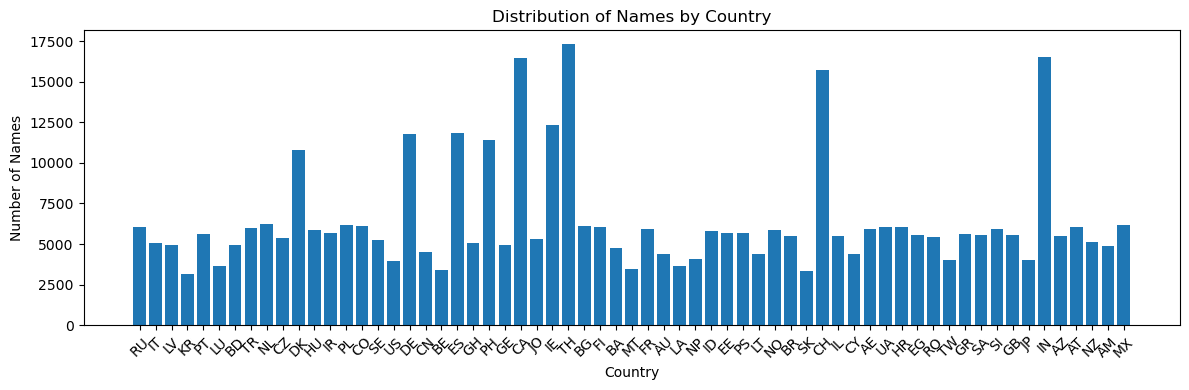

In [91]:
plt.figure(figsize=(12,4))
plt.bar(x,y)
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.xlabel('Country')
plt.ylabel('Number of Names')
plt.title('Distribution of Names by Country')
plt.tight_layout()
plt.show()

In [ ]:
# plt.scatter(range(cty_size), Dict_cty.values())

In [93]:
class Block(nn.Module):

    def __init__(self, fan_in):
        super().__init__()
        self.li = Linear(fan_in, fan_in, bias=False)
        self.bn = BatchNorm1d(fan_in)  # batchnorm

    def forward(self, x):
        x = x + F.tanh(self.bn(self.li(x))) # residue net
        return x
    
    def parameters(self):
        return self.li.parameters()+self.bn.parameters()

class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = Embedding(vocab_size, n_embd)
        self.country_embedding_table = Embedding(cty_size, n_embd_cty)        
        self.blocks = Sequential([Block(n_embd*block_size+n_embd_cty) for _ in range(n_layer)])
        self.linear_f = Linear(n_embd*block_size+n_embd_cty, vocab_size)

    def forward(self, idx, idx_cty, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B,T,C1)
        cty_emb = self.country_embedding_table(idx_cty) # (B,C2)
        x = torch.cat((tok_emb.view(B,-1), cty_emb),1) # (B,T*C1+C2)
        x = self.blocks(x) # (B,T*C1+C2)
        logits = self.linear_f(x) # (B,vocab_size)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    def parameters(self):
        return self.token_embedding_table.parameters()+ \
                self.country_embedding_table.parameters() + \
                self.blocks.parameters()+self.linear_f.parameters()

    def generate(self, idx, idx_cty, max_new_tokens=10, temperature=1.0):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            
            logits, loss = self(idx_cond, idx_cty)
            logits = logits / temperature
            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            if 'finished' not in locals():
                finished = torch.zeros(idx.size(0), dtype=bool, device=idx.device)

            idx_next[finished] = 0

            idx = torch.cat((idx, idx_next), dim=1)

            finished |= (idx_next.squeeze(1) ==0)

            if finished.all():
                print('All sequences finished early')
                break
                
            # if torch.isnan(probs).any() or torch.isinf(probs).any() or (probs < 0).any():
            #     print("Invalid probability values encountered. Stopping generation.")
            # idx_next = torch.multinomial(probs, num_samples=1)
            # if idx_next.item() == 0:
            #     print("End token generated. Stopping early.")
            #     break
            # idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [95]:
model = Model()

In [97]:
[i.shape for i in model.parameters()]

[torch.Size([53, 48]),
 torch.Size([63, 8]),
 torch.Size([248, 248]),
 torch.Size([248]),
 torch.Size([248]),
 torch.Size([248, 248]),
 torch.Size([248]),
 torch.Size([248]),
 torch.Size([248, 53]),
 torch.Size([53])]

In [99]:
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

140245


Model(
  (token_embedding_table): Embedding()
  (country_embedding_table): Embedding()
  (blocks): Sequential()
  (linear_f): Linear()
)

In [101]:
@torch.no_grad()
def eval_loss():
    model.eval()

    logits, loss = model(Xde, Cde, Yde)
    model.train()

    return loss.item(), loss.log10().item()

In [46]:
max_steps = 2000
eval_step = 100
batch_size = 32
lossi = []
lossT = []
lossD = []
learning_rate = 1e-2

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)

for i in range(max_steps):
    if i%eval_step == 0:
        model.eval()
        lossTr, lossDe = eval_loss()
        print(f'{i:7d}/{max_steps:7d}: {lossTr:.4f} {lossDe:.4f}')
        lossT.append(lossTr)
        lossD.append(lossDe)
        model.train()

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Cb, Yb = Xtr[ix], Ctr[ix], Ytr[ix]

    logits, loss = model(Xb, Cb, Yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/   2000: 5.1819 0.7145
      0/   2000 4.8861
    100/   2000: 3.0805 0.4886
    200/   2000: 2.9464 0.4693
    300/   2000: 2.8394 0.4532
    400/   2000: 2.7863 0.4450
    500/   2000: 2.7500 0.4393
    600/   2000: 2.7450 0.4385
    700/   2000: 2.7285 0.4359
    800/   2000: 2.7032 0.4319
    900/   2000: 2.7233 0.4351
   1000/   2000: 2.6984 0.4311
   1000/   2000 2.5542
   1100/   2000: 2.6902 0.4298
   1200/   2000: 2.6616 0.4251
   1300/   2000: 2.6662 0.4259
   1400/   2000: 2.6382 0.4213
   1500/   2000: 2.6380 0.4213
   1600/   2000: 2.6508 0.4234
   1700/   2000: 2.6377 0.4212
   1800/   2000: 2.6508 0.4234
   1900/   2000: 2.6302 0.4200


In [ ]:
for block in model.blocks.layers:
    block.bn.training = False

# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,c,y = {
        'train': (Xtr, Ctr, Ytr),
        'val': (Xde, Cde, Yde),
    }[split]
    logits, loss = model(x, c, y)
    print(split, loss.item())
    
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def eval_loss():
    _, lossTr = model(Xtr, Ctr, Ytr)
    _, lossDe = model(Xde, Cde, Yde)
    return lossTr.item(), lossDe.item()
    
split_loss('train')
split_loss('val')

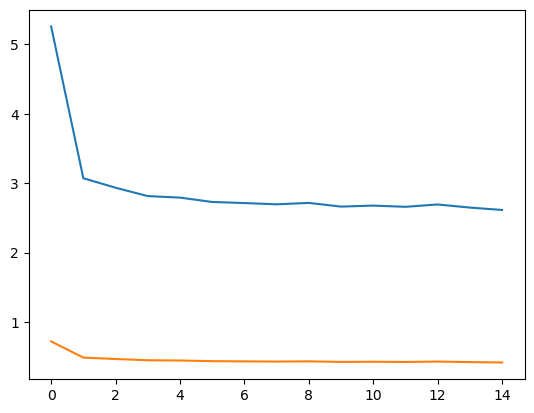

In [68]:
# plt.plot(torch.tensor(lossi).view(-1,100).mean(1))
plt.plot(torch.tensor(lossT))
plt.plot(torch.tensor(lossD))

In [107]:
model=Model()
g = torch.randint(low=0, high=vocab_size, size=(batch_size, block_size))
h = torch.randint(low=0, high=cty_size, size=(batch_size,))
output = model.generate(g, h, max_new_tokens=10, temperature=1.0)

decoded = [''.join([itos[i.item()] for i in row]) for row in output]

for i, name in enumerate(decoded):
    print(f'{i}: {name}')

0: rCDacQHeybrvpml
1:  OzrkFxHWdrIdvZ
2: Aj raLtdqLdJXYi
3: LAJUxTdFIxeFkFO
4: SImQSRIxF      
5: TbIGBLankYYLOfT
6: KSULNaOvNfLJDew
7:  wBvtHRbwCigQjA
8: QPNXBaXrLupSXLF
9: mRWOO          
10: lZsZHtybWLvIHVZ
11: hkWlBnyCmfSDzoF
12: jLVx yRLRgkVUcn
13: JZksxQfRDw     
14: xD bfHtQOmPbATA
15: WKDBoHrEKMybhlK
16: PLNYJVwhQEVMJwb
17: FNHiuZOAQjROmfX
18: XK IFpxNFkhtRFm
19: OcLM LWJ       
20: MIuahVdBOvUHCkF
21: lkiseCcdaXjDXCL
22: oIVKTVbvpQsVoXV
23: GrniJjhihGEwCwG
24: mAgKmwJfZJpGAsh
25: qbpSoFIFikpccNO
26: OjUuZmgEviGcScz
27: jjBkPztvdcntdRS
28: rzDIBqZtaaWuLSC
29: lFkvNWoMMGCRl  
30: CmhGejSxQblLoFS
31: jWbVGwMaWWHhCDu
